In [161]:
#### data I/O
import pandas as pd
import numpy as np
import json

In [9]:
df_spam_0 = pd.read_csv('../data/spam_ham_dataset.csv')

In [10]:
df_spam_0.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


## Preparing training data

In [61]:
#### Data Pre-processing for Kaggle dataset
import pandas as pd
from sklearn.model_selection import train_test_split


df = pd.read_csv("../data/spam_ham_dataset.csv")
df_sub =  df[["text","label_num"]]
df_sub.rename(columns = {"label_num":'label'}, inplace=True)
df_train,df_test = train_test_split(
        df_sub, \
    test_size=500, random_state=123, stratify=df_sub.label
    )
df_test,df_val = train_test_split(
        df_test, \
    test_size=250, random_state=123, stratify=df_test.label
    )

/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [59]:
#### Balancing the dataset
df_train.groupby('label').count()



,text
label,
0,3494
1,1427


In [ ]:
df_train,df_val = train_test_split(
        df_train, \
    test_size=250, random_state=123, stratify=df_test.label
    )

In [31]:
y_train = df_train.label
y_val = df_val.label
y_test = df_test.label

## Tokenizing text


In [18]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_spam_0.text)

In [28]:
vocab_size = len(tokenizer.word_index) + 1 

In [19]:
X_train = tokenizer.texts_to_sequences(df_train.text.values)
X_val = tokenizer.texts_to_sequences(df_val.text.values)
X_test = tokenizer.texts_to_sequences(df_test.text.values)


In [20]:
print(df_train.text.values[2])
print(X_train[2])

Subject: hpl nom for july 27 , 2000
( see attached file : hplo 727 . xls )
- hplo 727 . xls
[9, 48, 148, 6, 208, 250, 92, 93, 98, 169, 590, 121, 1, 590, 121]


In [21]:
 for word in ['the', 'all', 'happy', 'sad']:
...     print('{}: {}'.format(word, tokenizer.word_index[word]))   

the: 2
all: 57
happy: 1285
sad: 7540


In [22]:
from keras.preprocessing.sequence import pad_sequences

In [24]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)

In [25]:
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

## Defining metrics

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

## Defining the model

In [164]:
                                                                                                                                                from keras.models import Sequential
from keras import layers
from keras.models import Sequential

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=METRICS)
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 100, 50)           2893600   
                                                                 
 flatten_9 (Flatten)         (None, 5000)              0         
                                                                 
 dense_82 (Dense)            (None, 10)                50010     
                                                                 
 dense_83 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2,943,621
Trainable params: 2,943,621
Non-trainable params: 0
_________________________________________________________________


## Early stopping criteria is important

In [108]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [109]:
X_train.shape

(4671, 100)

In [110]:
from collections import Counter
Counter(y_train)

Counter({0: 3317, 1: 1354})

## Model fitting

In [167]:
## class weight is given since the dataset is imbalanced.

class_weight = {0: 1.,
                1: 2.5
                }

history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_val, y_val),
                    batch_size=10,
                   class_weight=class_weight,
                    callbacks=[early_stopping]
                   )



Restoring model weights from the end of the best epoch: 12.
Epoch 00022: early stopping


In [128]:
model.evaluate(X_train, y_train, verbose=False)

[0.05843326449394226,
 1354.0,
 78.0,
 3239.0,
 0.0,
 0.9833012223243713,
 0.9455307126045227,
 1.0,
 0.9985508322715759,
 0.995078444480896]

In [129]:
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

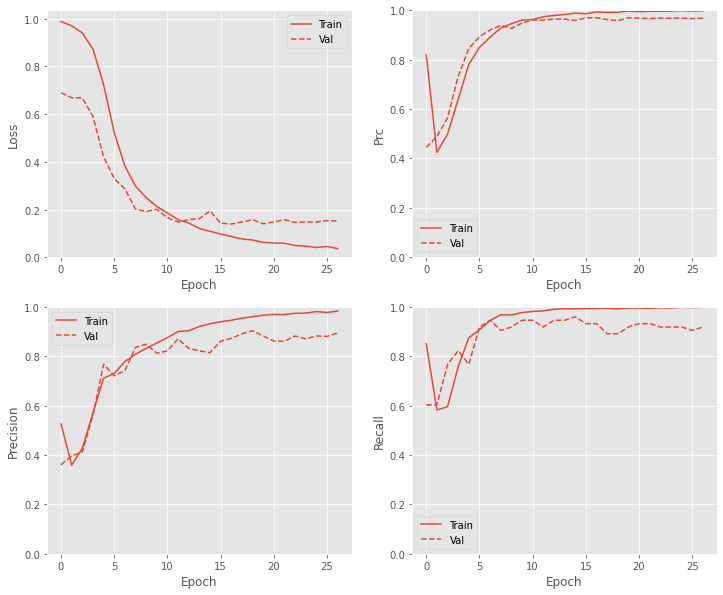

In [130]:
plot_metrics(history)

In [131]:
from sklearn.metrics import classification_report

In [132]:
y_pred_test_prob = model.predict(X_test)
y_pred_test = [1 if x>0.5 else 0 for x in y_pred_test_prob]

In [133]:
print(classification_report(y_pred_test,y_test))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       173
           1       0.94      0.88      0.91        77

    accuracy                           0.95       250
   macro avg       0.95      0.93      0.94       250
weighted avg       0.95      0.95      0.95       250



## Convolution neural networks.
## Hyper Parameter Tuning

In [144]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=METRICS),
                    
    return model

In [135]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [137]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [142]:
epochs = 30

In [145]:
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,validation_data=(X_val, y_val),
                            verbose=False,callbacks=[early_stopping])
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

/tmp/ipykernel_21254/993269596.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model,


INFO:tensorflow:Assets written to: ram://f1b90bf5-2045-44e9-8d18-9cd4a6aae5b8/assets
Fitting 4 folds for each of 5 candidates, totalling 20 fits
INFO:tensorflow:Assets written to: ram://45dfc38a-13a4-4c24-8447-185985f3432a/assets
INFO:tensorflow:Assets written to: ram://4c936f9c-7845-47f4-8ee1-1114580c42b6/assets
Restoring model weights from the end of the best epoch: 3.
Epoch 00013: early stopping
INFO:tensorflow:Assets written to: ram://ecfe98d4-06a3-4909-9bb1-a8118d2dfa7a/assets
INFO:tensorflow:Assets written to: ram://0c6de469-1661-46bf-ba56-e144a77c12d2/assets
INFO:tensorflow:Assets written to: ram://3d472b3e-a6ec-49aa-b6c3-33590b8d4400/assets
INFO:tensorflow:Assets written to: ram://4d837263-3e23-4179-90bf-a131f13a2f6a/assets
Restoring model weights from the end of the best epoch: 3.
Epoch 00013: early stopping
INFO:tensorflow:Assets written to: ram://b12cbca0-8956-4892-860f-5a108f819a1c/assets
INFO:tensorflow:Assets written to: ram://d549a60d-bf47-4ac7-af29-19fb00b80c4b/assets
R

In [146]:
test_accuracy = grid.score(X_test, y_test)

In [147]:
test_accuracy

0.9760000109672546

In [155]:
#plot_metrics(grid.best_estimator_)

In [158]:
grid.best_estimator_

In [153]:
grid.estimator

In [156]:
y_pred_test = grid.predict(X_test)

In [159]:
y_pred_test_prob = grid.predict(X_test)
y_pred_test = [1 if x>0.5 else 0 for x in y_pred_test_prob]

In [160]:
print(classification_report(y_pred_test,y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       180
           1       0.94      0.97      0.96        70

    accuracy                           0.98       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.98      0.98      0.98       250

